<a href="https://colab.research.google.com/github/QingyunSun/Create-your-Own-Dataset-AutoML/blob/main/Example_Code_for_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.8 MB/s eta 0:00:00


# New Section

# New Section

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel, pipeline
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle

torch.cuda.is_available()

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cdata = pd.read_csv('drive/MyDrive/FinLLM/data/cryptonews.csv')
cdata = cdata[cdata['subject'].isin(['Apple stock'])]
cdata['date'] = pd.to_datetime(cdata['date'])
cdata['dt_rounded'] = cdata['date'].dt.ceil('H')
cdata = cdata.sort_values('date')
# TODO: validate why sentiment label is not valid
cdata['sentiment_label'] = [eval(c)['class'] for c in cdata['sentiment']]

In [ ]:
price_data = pd.read_csv('drive/MyDrive/FinLLM/data/eth_btc_hourly.csv', index_col=0)
price_data['asset'] = ['ethereum' if t == 'ETH' else 'bitcoin' for t in price_data['ticker']]
price_data['ts'] = pd.to_datetime(price_data['ts'])
price_data = price_data.sort_values('ts')
# price_data['ts_asset'] = price_data['asset'] + price_data['ts'].astype(str)
# price_data['prev_price'] = price_data.groupby('asset').shift(1)['close']
# price_data['prev_price_2'] = price_data.groupby('asset').shift(2)['close']
price_data['next_price_1'] = price_data.groupby('asset').shift(-1)['close']
price_data['next_price_2'] = price_data.groupby('asset').shift(-2)['close']
price_data['next_price_3'] = price_data.groupby('asset').shift(-3)['close']
price_data['next_price_4'] = price_data.groupby('asset').shift(-4)['close']
price_data['next_price_6'] = price_data.groupby('asset').shift(-6)['close']
price_data['next_price_8'] = price_data.groupby('asset').shift(-8)['close']
price_data['next_price_10'] = price_data.groupby('asset').shift(-10)['close']
price_data['next_price_12'] = price_data.groupby('asset').shift(-12)['close']
price_data['ret_1'] = price_data['next_price_1']/price_data['close']
price_data['ret_2'] = price_data['next_price_2']/price_data['close']
price_data['ret_3'] = price_data['next_price_3']/price_data['close']
price_data['ret_4'] = price_data['next_price_4']/price_data['close']
price_data['ret_6'] = price_data['next_price_6']/price_data['close']
price_data['ret_8'] = price_data['next_price_8']/price_data['close']
price_data['ret_10'] = price_data['next_price_10']/price_data['close']
price_data['ret_12'] = price_data['next_price_12']/price_data['close']
price_data = price_data.dropna()

In [ ]:
data_df = cdata.merge(price_data, how='left', left_on=['subject', 'dt_rounded'], right_on=['asset', 'ts'])
data_df.columns

Index(['date', 'sentiment', 'source', 'subject', 'text', 'title', 'url',
       'dt_rounded', 'sentiment_label', 'ts', 'ticker', 'open', 'high', 'low',
       'close', 'created_at', 'asset', 'next_price_1', 'next_price_2',
       'next_price_3', 'next_price_4', 'next_price_6', 'next_price_8',
       'next_price_10', 'next_price_12', 'ret_1', 'ret_2', 'ret_3', 'ret_4',
       'ret_6', 'ret_8', 'ret_10', 'ret_12'],
      dtype='object')

In [ ]:
# DATA
# crypto news data
# https://figshare.com/articles/dataset/Cryptocurrency_News_Datasets/21989735

# equities news + tickers + date data
# https://www.kaggle.com/datasets/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests

# sentiment data
# https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news
# source is financial phrasebank - par of finbert finetuning dataset

In [ ]:
# SENTIMENT CLASSIFICATION

In [ ]:
%%time

# Sentiment analysis
class SentimentAnalyser:
    def __init__(self, model_name):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name).to(self.device)  # Move model to GPU
        self.classifier = pipeline('sentiment-analysis',
                                   model=self.model,
                                   tokenizer=self.tokenizer,
                                   device=0)  # Specify device here

    def predict(self, text):
        results = self.classifier(text)
        return [result['label'] for result in results]

sentiment_analyser = SentimentAnalyser('ProsusAI/finbert')
pred_out = sentiment_analyser.classifier(data_df['text'].values.tolist())

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


CPU times: user 1min 23s, sys: 2.93 s, total: 1min 26s
Wall time: 1min 48s


In [ ]:
# from sklearn.metrics import balanced_accuracy_score, classification_report, \
#     confusion_matrix

# EVAL
# TODO:
# sentiment classification eval
# ISSUE:
# provided sentiments in cryptonews.csv dataset are not ground-truth labels

# classification metrics
# print(balanced_accuracy_score(data_df['sentiment_label'], data_df['pred_label']))
# print(classification_report(data_df['sentiment_label'], data_df['pred_label']))
# print(pd.DataFrame(confusion_matrix(data_df['sentiment_label'], data_df['pred_label'])))

# y_test_plt = [1 if v == 1 else 0 for v in y_test['green']]
# pred_y_probs = clf.predict_proba(x_test)
# plot_roc_curve(y_test_plt, pred_y_probs[:,1])
# plot_precision_recall_curve(y_test_plt, pred_y_probs[:,1])

In [ ]:
data_df['pred'] = pred_out
data_df['pred_score'] = [p['score'] for p in data_df['pred']]
data_df['pred_label'] = [p['label'] for p in data_df['pred']]
data_df['label_int'] = [1 if p == 'positive' else \
                        0 if p == 'neutral' else \
                        -1 for p in data_df['pred_label']]

In [ ]:
plt_df = data_df[(data_df['pred_label'] != 'neutral') & (data_df['pred_score'] > 0.8)].copy().dropna()
# tst_df = data_df[(data_df['pred_score'] > 0.8)].copy()
# tst_df = tst_df[tst_df['asset'] == 'bitcoin']
plt_df['ret_1'] = 100*(plt_df['ret_1']-1)
plt_df['ret_2'] = 100*(plt_df['ret_2']-1)
plt_df['ret_3'] = 100*(plt_df['ret_3']-1)
plt_df['ret_4'] = 100*(plt_df['ret_4']-1)
plt_df['ret_6'] = 100*(plt_df['ret_6']-1)
plt_df['ret_8'] = 100*(plt_df['ret_8']-1)
plt_df['ret_10'] = 100*(plt_df['ret_10']-1)
plt_df['ret_12'] = 100*(plt_df['ret_12']-1)

col_list = ['ret_1', 'ret_2', 'ret_3', 'ret_4']#, 'ret_6', 'ret_8', 'ret_10', 'ret_12']

stats = plt_df.groupby('label_int')[col_list].agg(['mean'])
stats.reset_index(inplace=True)
stats.columns = ['sentiment_label',
                 'mean_1',
                 'mean_2',
                 'mean_3',
                 'mean_4']
stats_melt = stats.melt(id_vars='sentiment_label')
stats_melt[['statistic', 'window']] = stats_melt['variable'].str.split('_', n=1, expand=True)

stats2 = plt_df.groupby('label_int')[col_list].agg(['mean',
                                                   lambda x: x.quantile(0.05),
                                                   lambda x: x.quantile(0.95)])
stats2.reset_index(inplace=True)
stats2.columns = ['sentiment_label',
                 'mean_1', 'pct5_1', 'pct95_1',
                 'mean_2', 'pct5_2', 'pct95_2',
                 'mean_3', 'pct5_3', 'pct95_3',
                 'mean_4', 'pct5_4', 'pct95_4']
stats_melt2 = stats2.melt(id_vars='sentiment_label')
stats_melt2[['statistic', 'window']] = stats_melt2['variable'].str.split('_', n=1, expand=True)

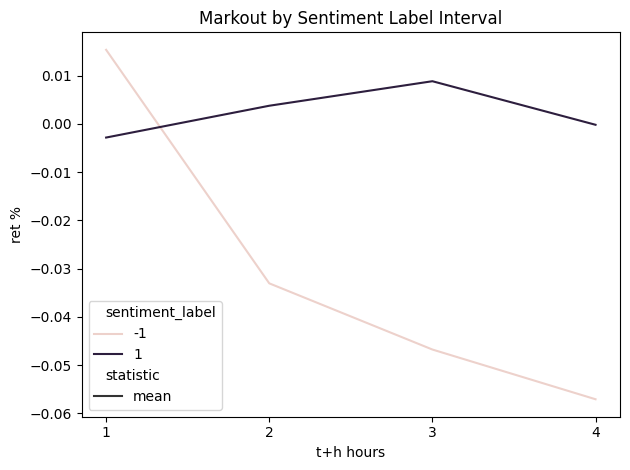

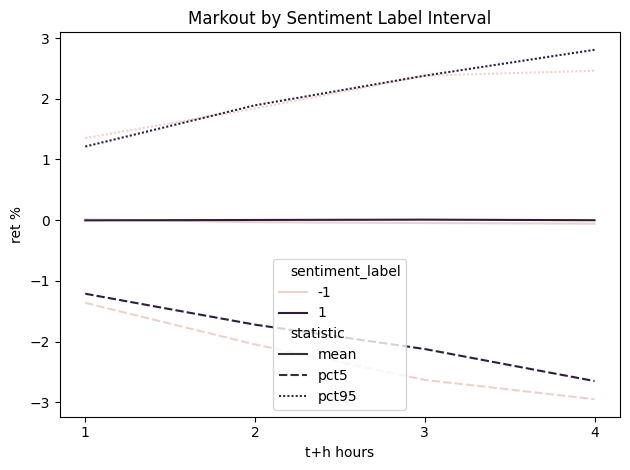

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()
# sns.reset_orig()

plt.figure()
sns.lineplot(data=stats_melt, x='window', y='value', hue='sentiment_label', style='statistic')
plt.xlabel('t+h hours')
plt.ylabel('ret %')
plt.title('Markout by Sentiment Label Interval')
plt.tight_layout()
plt.show()

plt.figure()
sns.lineplot(data=stats_melt2, x='window', y='value', hue='sentiment_label', style='statistic')
plt.xlabel('t+h hours')
plt.ylabel('ret %')
plt.title('Markout by Sentiment Label Interval')
plt.tight_layout()
plt.show()

In [ ]:
# ENCODE

In [ ]:
def preprocess_data(texts, tokenizer):
    encoded_corpus = tokenizer([text for text in texts],
                               add_special_tokens=True,
                               padding='max_length',
                               truncation='longest_first',
                               max_length=512)
    input_ids = encoded_corpus['input_ids']

    return input_ids

class SentimentEncoder:
    def __init__(self, model_name):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
        # self.model = AutoModel.from_pretrained(model_name, output_hidden_states=True).to(self.device)

    def encode(self, input_ids):
        # Ensure that texts is a list
        assert isinstance(input_ids, list), "Input should be a list"

        # Convert the list of lists into a tensor
        tensor_input = torch.tensor(input_ids).to(self.device)

        text_embeddings = []
        with torch.no_grad():
            for input_id in tensor_input:
                last_hidden_states = self.model(input_id.unsqueeze(0))
                # outputs = self.model(input_id.unsqueeze(0))
                # hidden_states = outputs[2]  # get hidden states

                # get the embedding of the [CLS] token which can be used as the embedding of the text
                text_embedding = last_hidden_states[0][:,0,:].cpu().numpy()

                # get the embedding of the [CLS] token from the last four layers
                # last_four_layers = [hidden_states[i][:,0,:].cpu().numpy() for i in [-4, -3, -2, -1]]
                # text_embedding = np.concatenate(last_four_layers, axis=1)  # concatenate vectors

                # Append to the list of embeddings
                text_embeddings.append(text_embedding[0])

        return np.array(text_embeddings)

tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
sentiment_encoder = SentimentEncoder('ProsusAI/finbert')

texts = ["Apple stock surged dramatically.", "Apple stock dropped dramatically."]
input_ids = preprocess_data(texts, tokenizer)
embedding = sentiment_encoder.encode(input_ids)

Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
%%time

input_ids = preprocess_data(data_df['text'].values.tolist(), tokenizer)
embeddings = sentiment_encoder.encode(input_ids)
embeddings.shape

CPU times: user 3min 24s, sys: 585 ms, total: 3min 25s
Wall time: 3min 33s


(5998, 768)

In [ ]:
# statsmodels regression w/ embeddings

In [ ]:
tst_df = data_df.copy()
tst_df['text_embedding'] = [tuple(e) for e in embeddings]
tst_df = tst_df.dropna()
train_x, test_x, train_y, test_y = train_test_split(tst_df[[c for c in data_df if 'ret' not in c]],
                                                    tst_df[[c for c in data_df if 'ret' in c]],
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
import statsmodels.api as sm

X = sm.add_constant(np.array([np.array(v) for v in train_x['text_embedding'].values]))
y = train_y['ret_4'].values

regr_model = sm.OLS(y, X)
regr_res = regr_model.fit()
# print(regr_res.summary())

from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, max_error, explained_variance_score, mean_pinball_loss
import scipy
from sklearn.metrics import balanced_accuracy_score, classification_report, \
    confusion_matrix

def get_regr_scores(y_true, y_pred):
    print('(rmse):', np.sqrt(mean_squared_error(y_true, y_pred)))
    print('(r2):', scipy.stats.pearsonr(y_true, y_pred)[0]**2)
    print('(mean_abs_error):', mean_absolute_error(y_true, y_pred))
    print('(median_abs_error):', median_absolute_error(y_true, y_pred))
    print('(max_error):', max_error(y_true, y_pred))
    print('(explained_var_score):', explained_variance_score(y_true, y_pred))
    print('(mean_pinball_loss):', mean_pinball_loss(y_true, y_pred))

test_X = sm.add_constant(np.array([np.array(v) for v in test_x['text_embedding'].values]))
test_pred_y = regr_res.predict(test_X)
print(get_regr_scores(test_y['ret_4'].values, test_pred_y))

test_pred_y_binary = [-1 if v-1 <= 0 else 1 for v in test_pred_y]
test_y_binary = [-1 if v-1 <= 0 else 1 for v in test_y['ret_4']]

# classification metrics
print(balanced_accuracy_score(test_y_binary, test_pred_y_binary))
print(classification_report(test_y_binary, test_pred_y_binary))
print(pd.DataFrame(confusion_matrix(test_y_binary, test_pred_y_binary)))

(rmse): 0.01885595360046065
(r2): 0.0015766535921738333
(mean_abs_error): 0.013508590171484997
(median_abs_error): 0.010207139346871785
(max_error): 0.1056126089923215
(explained_var_score): -0.21626288257477722
(mean_pinball_loss): 0.006754295085742499
None
0.523879968560521
              precision    recall  f1-score   support

          -1       0.53      0.54      0.54       610
           1       0.51      0.51      0.51       584

    accuracy                           0.52      1194
   macro avg       0.52      0.52      0.52      1194
weighted avg       0.52      0.52      0.52      1194

     0    1
0  331  279
1  289  295


         Current function value: 0.597262
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.5207275993712104
              precision    recall  f1-score   support

          -1       0.53      0.57      0.55       610
           1       0.51      0.47      0.49       584

    accuracy                           0.52      1194
   macro avg       0.52      0.52      0.52      1194
weighted avg       0.52      0.52      0.52      1194

     0    1
0  347  263
1  308  276


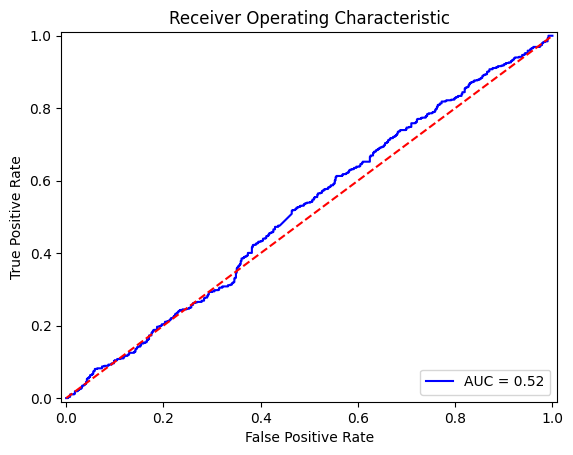

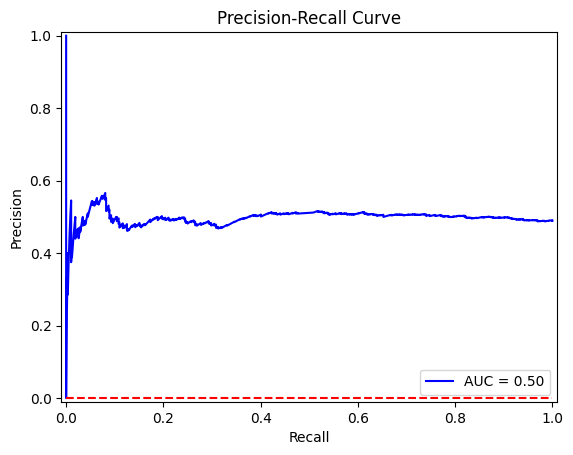

In [ ]:
X = sm.add_constant(np.array([np.array(v) for v in train_x['text_embedding'].values]))
y = [0 if v-1 <= 0 else 1 for v in train_y['ret_4'].values]

logit_model = sm.Logit(y, X)
logit_res = logit_model.fit()
# print(logit_res.summary())

from sklearn.metrics import balanced_accuracy_score, silhouette_score, classification_report, \
    confusion_matrix, roc_curve, precision_recall_curve, auc

def plot_roc_curve(y_test, preds):
    fpr, tpr, _ = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def plot_precision_recall_curve(y_test, preds):
    precision, recall, _ = precision_recall_curve(y_test, preds)
    pr_curve_auc = auc(recall, precision)
    plt.title('Precision-Recall Curve')
    plt.plot(recall, precision, 'b', label = 'AUC = %0.2f' % pr_curve_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 0],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

test_X = sm.add_constant(np.array([np.array(v) for v in test_x['text_embedding'].values]))
test_pred_y = logit_res.predict(test_X)
test_pred_y_binary = [-1 if v <= 0.5 else 1 for v in test_pred_y]
test_y_binary = [-1 if v-1 <= 0 else 1 for v in test_y['ret_4']]

# classification metrics
print(balanced_accuracy_score(test_y_binary, test_pred_y_binary))
print(classification_report(test_y_binary, test_pred_y_binary))
print(pd.DataFrame(confusion_matrix(test_y_binary, test_pred_y_binary)))

pred_y_probs = logit_res.predict(test_X)
plot_roc_curve(test_y_binary, pred_y_probs)
plot_precision_recall_curve(test_y_binary, pred_y_probs)

In [ ]:
# TODO:
# feature importance comparison
# adding ret_t-1, sigma_t-1 other numeric features

In [ ]:
# TRAIN

In [ ]:
import torch
from torch import nn
from torch.optim import AdamW
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.clip_grad import clip_grad_norm

def preprocess_data(dataset, tokenizer):
    encoded_corpus = tokenizer([text for text, _ in dataset],
                               padding='max_length',
                               truncation='longest_first',
                               max_length=512,
                               return_attention_mask=True)
    input_ids = torch.tensor(encoded_corpus['input_ids'])
    attention_mask = torch.tensor(encoded_corpus['attention_mask'])
    labels = torch.tensor([label for _, label in dataset])

    return input_ids, attention_mask, labels

def create_dataloaders(inputs, masks, labels, batch_size=32):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor,
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=True)
    return dataloader

# TODO:
# adjust final pooling layer to use all token embeddings
# current BertPooler uses first token to pool with tanh activation

class FinBertRegressor(nn.Module):
    def __init__(self, model_name, freeze_finbert=True, drop_rate=0.2):
        super(FinBertRegressor, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.finbert = AutoModel.from_pretrained(model_name).to(self.device)
        if freeze_finbert:
            # Freeze all the parameters in the pretrained model initially
            for param in self.finbert.parameters():
                param.requires_grad = False

            # Unfreeze the last 4 layers in the pretrained model
            # for param in list(self.finbert.encoder.layer[-4:].parameters()):
            #     param.requires_grad = True

        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(768, 1)).to(self.device)

    def forward(self, input_ids, attention_masks):
        pooled_output = self.finbert(input_ids, attention_masks)
        class_label_output = pooled_output[1]
        outputs = self.regressor(class_label_output)
        return outputs

In [ ]:
%%time

# dataset = [("This is some financial text data", 0.01),
#            ("More financial text data", -0.02)]
tst_df = data_df.dropna()
dataset = [tuple(val) for val in tst_df[['text', 'ret_4']].values.tolist()]

batch_size = 32

tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
input_ids, attention_mask, labels = preprocess_data(dataset, tokenizer)

# Split data into train, test datasets
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids,
                                                                        labels,
                                                                        test_size=0.2,
                                                                        random_state=42)

train_masks, test_masks, _, _ = train_test_split(attention_mask,
                                                 labels,
                                                 test_size=0.2,
                                                 random_state=42)

scaler = StandardScaler()
train_labels = scaler.fit_transform(train_labels.reshape(-1,1)).astype(np.float32)
test_labels = scaler.transform(test_labels.reshape(-1,1)).astype(np.float32)

train_dataloader = create_dataloaders(train_inputs, train_masks,
                                      train_labels, batch_size)
test_dataloader = create_dataloaders(test_inputs, test_masks,
                                     test_labels, batch_size)

CPU times: user 2.57 s, sys: 265 ms, total: 2.83 s
Wall time: 2.3 s


<ipython-input-12-8417532cd60c>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(inputs)
<ipython-input-12-8417532cd60c>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_tensor = torch.tensor(masks)


In [ ]:
%%time

epochs = 10
model = FinBertRegressor('ProsusAI/finbert', drop_rate=0.2)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
model.to(device)

loss_fn = nn.MSELoss()
optimizer = AdamW(model.parameters(),
                  lr=5e-5,
                  eps=1e-8)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                 num_warmup_steps=0, num_training_steps=total_steps)

def train(model, optimizer, scheduler, loss_fn, epochs,
          train_dataloader, test_dataloader, device, clip_value):
    train_losses = []
    test_losses = []
    for epoch in range(1, epochs+1):
        print('epoch:', epoch)
        print('------------------')
        model.train()
        total_train_loss = 0
        for step, batch in enumerate(train_dataloader):
            print('train_step:', step)
            batch_inputs, batch_masks, batch_labels = \
                tuple(b.to(device) for b in batch)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)
            loss = loss_fn(outputs.squeeze(),
                           batch_labels.squeeze())
            total_train_loss += loss.item()
            loss.backward()
            clip_grad_norm(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Evaluation
        model.eval()
        total_eval_loss = 0
        for step, batch in enumerate(test_dataloader):
            print('test_step:', step)
            batch_inputs, batch_masks, batch_labels = \
                tuple(b.to(device) for b in batch)
            with torch.no_grad():
                outputs = model(batch_inputs, batch_masks)
                # print(outputs.squeeze(), batch_labels.squeeze())
                loss = loss_fn(outputs.squeeze(),
                               batch_labels.squeeze())
            total_eval_loss += loss.item()

        avg_test_loss = total_eval_loss / len(test_dataloader)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch}, Train loss: {avg_train_loss}, Validation loss: {avg_test_loss}")

    return train_losses, test_losses

train_losses, test_losses = train(model,
      optimizer,
      scheduler,
      loss_fn,
      epochs,
      train_dataloader,
      test_dataloader,
      device,
      clip_value=2)

# TODO: Add validation data evaluation

<ipython-input-6-8417532cd60c>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(inputs)
<ipython-input-6-8417532cd60c>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_tensor = torch.tensor(masks)
Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that yo

Using GPU.
epoch: 1
------------------
train_step: 0


<timed exec>:70: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


train_step: 1
train_step: 2
train_step: 3
train_step: 4
train_step: 5
train_step: 6
train_step: 7
train_step: 8
train_step: 9
train_step: 10
train_step: 11
train_step: 12
train_step: 13
train_step: 14
train_step: 15
train_step: 16
train_step: 17
train_step: 18
train_step: 19
train_step: 20
train_step: 21
train_step: 22
train_step: 23
train_step: 24
train_step: 25
train_step: 26
train_step: 27
train_step: 28
train_step: 29
train_step: 30
train_step: 31
train_step: 32
train_step: 33
train_step: 34
train_step: 35
train_step: 36
train_step: 37
train_step: 38
train_step: 39
train_step: 40
train_step: 41
train_step: 42
train_step: 43
train_step: 44
train_step: 45
train_step: 46
train_step: 47
train_step: 48
train_step: 49
train_step: 50
train_step: 51
train_step: 52
train_step: 53
train_step: 54
train_step: 55
train_step: 56
train_step: 57
train_step: 58
train_step: 59
train_step: 60
train_step: 61
train_step: 62
train_step: 63
train_step: 64
train_step: 65
train_step: 66
train_step: 67
trai

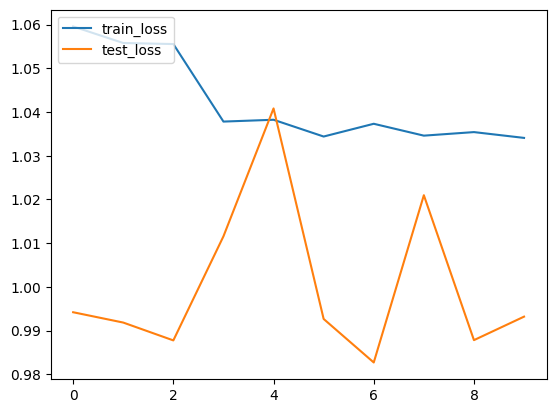

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
with open('drive/MyDrive/FinLLM/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
torch.save(model.state_dict(), 'drive/MyDrive/FinLLM/finbert_ret_regr_finetuned.pth')

In [ ]:
def text_inference(text_data, model_path, scaler_path):
    # Load the StandardScaler
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    # Initialize tokenizer and model from saved checkpoint
    tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
    model = FinBertRegressor('ProsusAI/finbert')
    model.load_state_dict(torch.load(model_path))
    model.to('cuda')

    # Preprocess the data
    encoded_corpus = tokenizer(text_data,
                               padding='max_length',
                               truncation=True,
                               max_length=512,
                               return_attention_mask=True,
                               return_tensors='pt')
    input_ids = encoded_corpus['input_ids'].to('cuda')
    attention_mask = encoded_corpus['attention_mask'].to('cuda')

    # Prepare the data loader
    dataset = TensorDataset(input_ids, attention_mask)
    data_loader = DataLoader(dataset, batch_size=32)

    # Inference
    model.eval()
    results = []
    with torch.no_grad():
        for input_ids, attention_mask in data_loader:
            output = model(input_ids, attention_mask).squeeze()
            output_cpu = output.cpu().numpy()
            output_inverse = scaler.inverse_transform(output_cpu.reshape(-1, 1))
            results.extend(output_inverse.squeeze().tolist())

    return results

def inference(text_input_ids, text_attention_masks, model_path, scaler_path):
    # Load the StandardScaler
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    # Initialize model from saved checkpoint
    model = FinBertRegressor('ProsusAI/finbert')
    print(model)
    model.load_state_dict(torch.load(model_path))
    model.to('cuda') # Load model on the same device as before

    input_ids = text_input_ids.to('cuda')
    attention_mask = text_attention_masks.to('cuda')

    # Prepare the data loader
    dataset = TensorDataset(input_ids, attention_mask)
    data_loader = DataLoader(dataset, batch_size=32)

    # Inference
    model.eval()
    results = []
    with torch.no_grad():
        for input_ids, attention_mask in data_loader:
            output = model(input_ids, attention_mask).squeeze()
            output_cpu = output.cpu().numpy()
            output_inverse = scaler.inverse_transform(output_cpu.reshape(-1, 1))
            results.extend(output_inverse.squeeze().tolist())

    return results

nn_test_pred_y = inference(test_inputs, test_masks,
                          'drive/MyDrive/FinLLM/finbert_ret_regr_finetuned.pth',
                          'drive/MyDrive/FinLLM/scaler.pkl')

Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


FinBertRegressor(
  (finbert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
text_inference(['Ethereum is rallying after recent upgrade.',
                'Ethereum is crashing after recent SEC lawsuit.'],
               'drive/MyDrive/FinLLM/finbert_ret_regr_finetuned.pth',
               'drive/MyDrive/FinLLM/scaler.pkl')

Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[1.0005446672439575, 0.997876763343811]

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, max_error, explained_variance_score, mean_pinball_loss
import scipy
from sklearn.metrics import balanced_accuracy_score, classification_report, \
    confusion_matrix

def get_regr_scores(y_true, y_pred):
    print('(rmse):', np.sqrt(mean_squared_error(y_true, y_pred)))
    print('(r2):', scipy.stats.pearsonr(y_true, y_pred)[0]**2)
    print('(mean_abs_error):', mean_absolute_error(y_true, y_pred))
    print('(median_abs_error):', median_absolute_error(y_true, y_pred))
    print('(max_error):', max_error(y_true, y_pred))
    print('(explained_var_score):', explained_variance_score(y_true, y_pred))
    print('(mean_pinball_loss):', mean_pinball_loss(y_true, y_pred))

test_y = scaler.inverse_transform(test_labels).reshape(-1)
print(get_regr_scores(test_y, nn_test_pred_y))

test_pred_y_binary = [-1 if v-1 <= 0 else 1 for v in nn_test_pred_y]
test_y_binary = [-1 if v-1 <= 0 else 1 for v in test_y]

# classification metrics
print(balanced_accuracy_score(test_y_binary, test_pred_y_binary))
print(classification_report(test_y_binary, test_pred_y_binary))
print(pd.DataFrame(confusion_matrix(test_y_binary, test_pred_y_binary)))

(rmse): 0.01714428021078132
(r2): 3.860872613791502e-06
(mean_abs_error): 0.0114932385720999
(median_abs_error): 0.007462799549102783
(max_error): 0.10232418775558472
(explained_var_score): -0.004927874572265845
(mean_pinball_loss): 0.00574661928604995
None
0.5051987424208398
              precision    recall  f1-score   support

          -1       0.51      0.80      0.63       610
           1       0.50      0.21      0.29       584

    accuracy                           0.51      1194
   macro avg       0.51      0.51      0.46      1194
weighted avg       0.51      0.51      0.46      1194

     0    1
0  491  119
1  464  120
